In [2]:
import logging, netCDF4, pickle, os, glob

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import shapely.geometry as sg
import geopandas as gpd 
from shapely.ops import cascaded_union

logging.basicConfig(level = logging.INFO)

# Change Paths to your computer!
path_data   = r'/Users/dlopez/Desktop/india_power/Software/'
path_images = r'/Users/dlopez/Desktop/india_power/Images/'

In [4]:
with open(path_data + r'india_power_dataset.pkl', 'rb') as _file:
    load_, mapre_, capacity_ = pickle.load(_file)
    L_, time_                = load_  
    S_proj_, W_proj_         = mapre_
    S_cf_, W_cf_             = capacity_
    
s_np_, s_names_, s_lon_, s_lat_, s_area_ = S_proj_
w_np_, w_names_, w_lon_, w_lat_, w_area_ = W_proj_
print(s_np_.shape, s_names_.shape, s_lon_.shape, s_lat_.shape, s_area_.shape)
print(w_np_.shape, w_names_.shape, w_lon_.shape, w_lat_.shape, w_area_.shape)

# Remove leap years - bad processing in winter
#S_cf_ = np.delete(S_cf_, [0, 4, 8, 12], axis = 2)
#W_cf_ = np.delete(W_cf_, [0, 4, 8, 12], axis = 2)
print(S_cf_.shape, W_cf_.shape)

s_cf_ = np.mean(np.mean(S_cf_, axis = 1), axis = 1)
w_cf_ = np.mean(np.mean(W_cf_, axis = 1), axis = 1)
print(s_cf_.shape, w_cf_.shape)

(566,) (566,) (566,) (566,) (566,)
(311,) (311,) (311,) (311,) (311,)
(566, 8760, 18) (311, 8760, 18)
(566,) (311,)


Energy demand in India, repated and reshaped to match the 18 years of generation.

In [5]:
N_days   = 365 
N_hours  = 24
N_years  = W_cf_.shape[-1]
N_states = L_.shape[-1]
# hourly energy demand in India
l_          = np.sum(L_ , axis = 1)[:, np.newaxis]
L_repeated_ = np.repeat(l_, N_years, axis = 1)
print(l_.shape, L_repeated_.shape)

# Total energy demand of India
L = np.sum(l_, axis = 0) 
print(L)

# Daily Total energy demand of India
L_reshaped_ = L_.reshape(N_days, N_hours, N_states) 
#L_daily_    = np.sum(np.sum(L_reshaped_,axis = 2) , axis = 1)[:,np.newaxis]
print(L_repeated_.shape)

(8760, 1) (8760, 18)
[2259974025]
(8760, 18)


Energy generate for each potential renewable energy zone for each hour of the 18 years available.
* Solar energy generation per solar zone
* Wind energy generation per wind zone

In [6]:
S_np_prime_ = np.repeat(s_np_[..., np.newaxis], N_hours*N_days, axis = 1)
S_np_       = np.repeat(S_np_prime_[..., np.newaxis], N_years, axis = 2)
W_np_prime_ = np.repeat(w_np_[..., np.newaxis], N_hours*N_days, axis = 1)
W_np_       = np.repeat(W_np_prime_[..., np.newaxis], N_years, axis = 2)

# Number of renewable energy zones
N_s_zones = s_np_.shape[0]
N_w_zones = w_np_.shape[0]

# Energy Generation Solar System
E_s_ = S_np_ * S_cf_
print(E_s_.shape, S_cf_.shape)

# Energy Generation Wind System
E_w_ = W_np_ * W_cf_
print(E_w_.shape, W_cf_.shape)

(566, 8760, 18) (566, 8760, 18)
(311, 8760, 18) (311, 8760, 18)


Function to define storage capacity for the simulation:
* b stands for batteries (SDS).
* h stands for hydrogen (LDS).
* $\rho$ is the system efficiency.
* $\eta$ self-distarge rate.
* $\beta$ combustible mixing ratio LDS).

In [7]:
# Run-Trip Efficiency
b_rho = 0.9
h_rho = 0.49

# Self-Discharge Rate
b_eta = .99998656 #.99/(365*24)
h_eta = .99999342 #.9999/(365*24)

# Mixing Ratio
b_beta = 1.
h_beta = .5

# Leave system paramters in format for simulation function
rho_, eta_, beta_  = [b_rho, h_rho], [b_eta, h_eta], [b_beta, h_beta]

Cost of the system (ATB report from NREL):
* (ins) project building cost per nameplate capacity
* (onm) O&M cost per nameplate capacity and year of operation 
* (lc) project lifecycle (lc)
* (c) total cost of the project

In [8]:
# Solar Project Cost
p_ins_solar = 2105.
p_onm_solar = 22.02
lc_solar    = 30.
c_s_ins     = p_ins_solar + p_onm_solar*lc_solar

# Wind Project Cost
p_ins_wind  = 1657
p_onm_wind  = 47.47
lc_wind     = 30.
c_w_ins     = p_ins_wind + p_onm_wind*lc_wind
renewable_  = [c_s_ins, c_w_ins]

# Battery Project Cost
p_ins_b_io = 1568
p_onm_b    = 0.
e_ins_b    = 261
lc_b       = 10.
c_b_ins_io = p_ins_b_io + p_onm_b*lc_b
battery_   = [3.*e_ins_b, 3.*c_b_ins_io]

# Hydrogen Project Cost
p_ins_h_i = 1058
p_ins_h_o = 5854
p_onm_h   = 0.
e_ins_h   = .16
lc_h      = 30.
c_h_ins_i = p_ins_h_i + p_onm_h*lc_h
c_h_ins_o = p_ins_h_o + p_onm_h*lc_h
hydrogen_ = [e_ins_h, c_h_ins_i, c_h_ins_o]

# System Costs Set
costs_ = [renewable_, battery_, hydrogen_]

Load system simulation functions
* _storage_model: charge and discharge of storage units during simulations
* _eval_system_cost: estimate cost of the system given a set of parameters
* _storage_capacity: as a function of the average demand of energy in India
* _simulate_scenario: simulate the operation of the system for the given number of years

In [110]:
# Piecewise Storage Dispatch and Charge Model
def _storage_model(L_net, SOC, Pr_i, Pr_o, Cap, rho, eta, beta): 
    
    # Storage To Power
    def __discarge(L_net, SOC, rho, beta):
        # Is there Energy for dispatching All Energy necessary?
        E_dispatched = (beta*abs(L_net))/rho
        # Dispatch necessary
        if E_dispatched <= SOC: 
            SOC -= E_dispatched
        # If Not Dispatch all what is available
        else:
            E_dispatched = SOC 
            SOC          = 0.
        return (E_dispatched*rho)/beta, SOC 
    
    # Power To Storage
    def __charge(L_net, SOC, Cap):
        # Is there Capacity for Storing All Energy?
        E_charged = abs(L_net)
        # Store Necessary
        if (SOC + E_charged) <= Cap:
            SOC += E_charged 
        # If not Store all what is possible
        else:
            E_charged = Cap - SOC 
            SOC       = Cap         
        return E_charged, SOC
    
    # Hourly Discharge Rate
    SOC *= eta

    # Shedding Event
    if L_net > 0.:
        
        # Limit Dispatch to the Rated Power
        if abs(L_net) > Pr_o:
            E_o = Pr_o
        else:
            E_o = L_net
        
        E_dispatched, SOC_star = __discarge(E_o, SOC, rho, beta) 
        return L_net - E_dispatched, SOC_star, - E_dispatched/Pr_o
    
    # Balanced Event
    if L_net == 0.: 
        return L_net, SOC, 0.
    
    # Curtailment Event
    if L_net < 0.:
        
        # Limit Charging to the Rated Power
        if abs(L_net) > Pr_i:
            E_i = Pr_i
        else:
            E_i = L_net
            
        E_charged, SOC_star = __charge(E_i, SOC, Cap)
        return L_net + E_charged, SOC_star, E_charged/Pr_i

# Compute the cost of the system configuration
def _eval_system_cost(costs_, params_):
    # Unpack Costs Per Energy Source
    renewable_, battery_, hidrogen_ = costs_
    c_s_ins, c_w_ins                = renewable_
    e_ins_b, c_b_ins_io             = battery_
    e_ins_h, c_h_ins_i, c_h_ins_o   = hidrogen_
    
    # Unpack Desgined System Parameters Per Energy Source
    renewable_, battery_, hidrogen_ = params_
    P_s_ins, P_w_ins                = renewable_
    E_b_Cap, P_b_ins_i, P_b_ins_o   = battery_
    E_h_Cap, P_h_ins_i, P_h_ins_o   = hidrogen_

    # Compute Cost per Energy Source
    C_s = P_s_ins*c_s_ins
    C_w = P_w_ins*c_w_ins
    
    if E_b_Cap == 0.: 
        C_b = 0.
    else:
        C_b = E_b_Cap*e_ins_b + c_b_ins_io*(P_b_ins_i + P_b_ins_o)/2.
        
    if E_h_Cap == 0.: 
        C_h = 0.
    else:
        C_h = E_h_Cap*e_ins_h + c_h_ins_i*P_h_ins_i + c_h_ins_o*P_h_ins_o
    
    # Compute Total System Cost
    return C_s + C_w + 3.*C_b + C_h

# Define Storage Sources
def _storage_capacity(l_, b_Cap, h_Cap, h_cr = 2., h_dr = 1.):
    
    # Power Rate Battery Bank
    b_Pr_i = 1.*(l_.sum()/l_.shape[0])
    b_Pr_o = 1.*(l_.sum()/l_.shape[0])
    #print(b_Pr_i, b_Pr_o)

    # Power Rate Hydrogen Electrolizer / Turbines
    h_Pr_i = h_cr*(l_.sum()/l_.shape[0])
    h_Pr_o = h_dr*(l_.sum()/l_.shape[0])
    #print(h_Pr_i, h_Pr_o)

    # Battery Back Capaticity
    b_Cap = b_Cap*b_Pr_o

    # Hydrogen Back Capaticity
    h_Cap = 24*h_Cap*h_Pr_o
    
    return [b_Pr_i, h_Pr_i], [b_Pr_o, h_Pr_o], [b_Cap, h_Cap]

# Simulate Energy System Operation
def _simulate_scenario(s_alpha_, w_alpha_, params_):
    
    # Unpack System Parameters
    energy_, storage_                     = params_
    E_s_, E_w_, l_                        = energy_
    pr_i_, pr_o_, cap_, rho_, eta_, beta_ = storage_
    
    # Get Sumulation Dimensions
    N_s_zones, N_hours_per_year, N_years = E_s_.shape
    N_w_zones, N_hours_per_year, N_years = E_w_.shape
    #print(E_s_.shape, E_w_.shape, s_alpha_.shape, w_alpha_.shape)

    # Vector Variables Initialization
    l_net_ = np.zeros((N_hours_per_year*N_years, ))
    b_net_ = np.zeros((N_hours_per_year*N_years, ))
    h_net_ = np.zeros((N_hours_per_year*N_years, ))

    b_soc_ = np.zeros((N_hours_per_year*N_years, ))
    h_soc_ = np.zeros((N_hours_per_year*N_years, ))

    b_Cap_ = np.zeros((N_hours_per_year*N_years, ))
    h_Cap_ = np.zeros((N_hours_per_year*N_years, ))
    
    # Repeath year of load
    l_prime_   = np.concatenate(([l_ for i in range(N_years)]), axis = 0)
    E_s_prime_ = np.concatenate(([E_s_[..., i] for i in range(E_s_.shape[-1])]), axis = 1)
    E_w_prime_ = np.concatenate(([E_w_[..., i] for i in range(E_w_.shape[-1])]), axis = 1)
    #print(E_s_prime_.shape, E_w_prime_.shape)
    
    # Compute Hourly Renewable Energy Generation
    e_s_ = s_alpha_.T @ E_s_prime_
    e_w_ = w_alpha_.T @ E_w_prime_
    #print(e_s_.shape, e_w_.shape)

    # Loop over time instants
    for i in range(N_hours_per_year*N_years):
        
        # Define Time as a loop
        if i == 0: j = -1
        else:      j = i - 1
            
        # Compute hourly net demand
        l_net_[i] = l_prime_[i] - (e_s_[i] + e_w_[i])
        
        # Compute Batteries Charge/Discharge
        b_net_[i], b_soc_[i], b_Cap_[i] = _storage_model(l_net_[i], b_soc_[j], pr_i_[0], pr_o_[0], cap_[0], rho_[0], eta_[0], beta_[0])
        
        # Compute Hydrogen Charge/Discharge
        h_net_[i], h_soc_[i], h_Cap_[i] = _storage_model(b_net_[i], h_soc_[j], pr_i_[1], pr_o_[1], cap_[1], rho_[1], eta_[1], beta_[1])

    # Reshape Similations to Hours x Year
    E_s_ = np.around(e_s_.reshape(N_years, N_hours_per_year)).T
    E_w_ = np.around(e_w_.reshape(N_years, N_hours_per_year)).T

    L_net_ = np.around(l_net_.reshape(N_years, N_hours_per_year)).T
    B_net_ = np.around(b_net_.reshape(N_years, N_hours_per_year)).T
    H_net_ = np.around(h_net_.reshape(N_years, N_hours_per_year)).T
    
    B_soc_ = b_soc_.reshape(N_years, N_hours_per_year).T
    H_soc_ = h_soc_.reshape(N_years, N_hours_per_year).T
    
    B_Cap_ = b_Cap_.reshape(N_years, N_hours_per_year).T
    H_Cap_ = h_Cap_.reshape(N_years, N_hours_per_year).T
    
    return H_net_, H_soc_, H_Cap_

# Expected Unserved Energy
def _EUE(L_net_):
    return L_net_[L_net_ > 0.].sum()/L_net_.shape[-1]

# Loss-Of-Load Probability
def _LOLP(L_net_):
    N_hours_year, N_years = L_net_.shape
    return 100.*(L_net_ > 0.).sum()/(N_hours_year*N_years)

# Loss-Of-Load-Expectation
def _LOLE(L_net_):
    N_hours_year, N_years = L_net_.shape
    N_days = int(N_hours_year/24)
    L_net_prime_ = np.reshape(L_net_, (N_days, 24, N_years))
    LOLE = 0.
    for i in range(N_years):
        for j in range(N_days):
            if (L_net_prime_[j, :, i] > 0.).sum() > 0:
                LOLE += 1.
    return LOLE/N_years

Run simulations for a given set of paramters
* (s_Cap_r) Fraction of the solar energy zones
* (w_Cap_r) Fraction of the wind energy zones
* (b_Cap_r) hydrogen hours of average india demand 
* (h_Cap_r) hydrogen hours of average india demand 

In [111]:
# David builts a for loop to simulate of the parametrs 
# Initialize Storage Varaibles


# ------- Enter Simualtion Parameters ----------

# Percentage of Solar Zones 
s_Cap_r = 1
# Percentage of Wind Zones 
w_Cap_r = 1
# Hours of demand in Battery Capacity
b_Cap_r = 4.
# Days of demand Hydrogen Capacity
h_Cap_r = 0.

# List of the Capacity Install for each source
Cap_r_ = [s_Cap_r, w_Cap_r, b_Cap_r, h_Cap_r]

# ------- Do Simulation ----------

# Hourly Energy Generated by Solar and Wind Potential Zones
energy_ = [E_s_, E_w_, l_]
# Select Zones Uniformly
s_Cap_ = np.ones(s_np_.shape)*s_Cap_r
w_Cap_ = np.ones(w_np_.shape)*w_Cap_r
# Compute Storage Design Specification given paramters
Pr_i_, Pr_o_, Cap_ = _storage_capacity(l_, b_Cap_r, h_Cap_r, h_cr = 1., h_dr = 1.)
storage_           = [Pr_i_, Pr_o_, Cap_, rho_, eta_, beta_]
# Simulate System Operation
H_net_1, H_soc_, H_Cap_ = _simulate_scenario(s_Cap_, w_Cap_, params_ = [energy_, storage_])

# Get this in your system simulation storage variable

# # ------- Evaluate Simualtion ----------

# # Compute System Metrics
# EUE  = _EUE(H_net_)
# LOLP = _LOLP(H_net_)
# LOLE = _LOLE(H_net_)
# print(EUE, LOLP, LOLE)

# # Get this in your metrics in storage variable

# # ------- Compute Costs ----------

# # Renewable Design Specification given paramters
# s_Pr_o_    = s_np_.T @ s_Cap_
# w_Pr_o_    = w_np_.T @ w_Cap_
# renewable_ = [s_Pr_o_, w_Pr_o_]
# print(renewable_)

# # Batteries Design Specification given paramters
# battery_ = [Cap_[0], Pr_i_[0], Pr_o_[0]]
# print(battery_)

# # Hydrogen Design Specification given paramters
# hidrogen_ = [Cap_[1], Pr_i_[1], Pr_o_[1]]
# print(hydrogen_)

# # Compute System Costs
# cost = _eval_system_cost(costs_, params_ = [renewable_, battery_, hydrogen_])
# print(cost)

# # Get your system Costs is a storage variable



In [116]:
H_net_1_prime = np.mean(H_net_1,axis =1)[:,np.newaxis]
print(H_net_1_prime.shape)

(8760, 1)


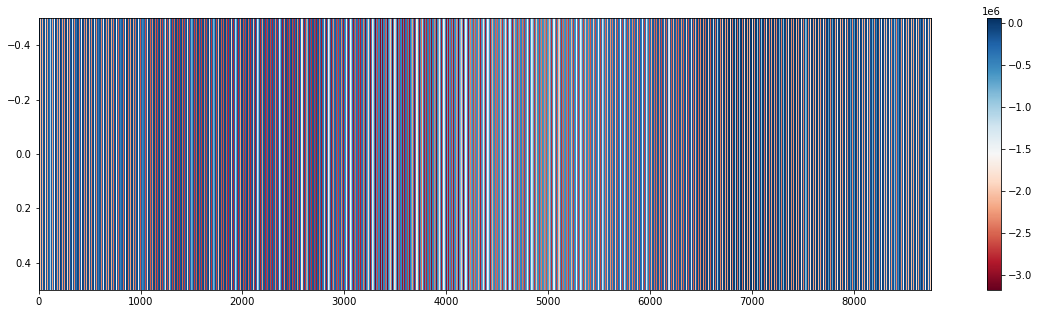

In [117]:
plt.figure(figsize = (20, 5))
plt.imshow(H_net_1_prime.T, aspect = 'auto', interpolation = 'none', cmap = 'RdBu')
plt.colorbar()
plt.show()


# TestBed


In [128]:
S_Cap_r_ = [0.,.25]   #,.50,.75,1]
W_Cap_r_ = [0,.25]     #[0.,.25,.50,.75,1]
B_Cap_r_  = [0.,1.]    #,2.,3.,4.,5.,6.]
H_Cap_r_ = [0.,1.]     #,2.,3.,4.,5.,6.,.7]

H_net_= []
variables_ = []
for i in range((len(S_Cap_r_))) :
    for j in range(len(W_Cap_r_)) :
        for k in range(len(B_Cap_r)) :
            for l in range(len(H_Cap_r_)) :
                energy_ = [E_s_, E_w_, l_]
                # Select Zones Uniformly
                s_Cap_ = np.ones(s_np_.shape)*S_Cap_r_[i]
                w_Cap_ = np.ones(w_np_.shape)*W_Cap_r_[j]
                # Compute Storage Design Specification given paramters
                Pr_i_, Pr_o_, Cap_ = _storage_capacity(l_, B_Cap_r_[k], H_Cap_r_[l], h_cr = 1., h_dr = 1.)
                storage_           = [Pr_i_, Pr_o_, Cap_, rho_, eta_, beta_]
                # Simulate System Operation
                H_net, H_soc, H_Cap = _simulate_scenario(s_Cap_, w_Cap_, params_ = [energy_, storage_])
                H_net_.append(H_net)
                variables_.append([S_Cap_r_[i],W_Cap_r_[j],B_Cap_r_[k],H_Cap_r_[l]])
H_net_ = np.array(H_net_)

In [131]:
print(H_net_.shape)
H_net_prime_ = np.mean(H_net_,axis=2)
H_net_prime_.shape

print(np.array(variables_))

(16, 8760, 18)
[[0.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   1.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.25 0.   1.  ]
 [0.   0.25 1.   0.  ]
 [0.   0.25 1.   1.  ]
 [0.25 0.   0.   0.  ]
 [0.25 0.   0.   1.  ]
 [0.25 0.   1.   0.  ]
 [0.25 0.   1.   1.  ]
 [0.25 0.25 0.   0.  ]
 [0.25 0.25 0.   1.  ]
 [0.25 0.25 1.   0.  ]
 [0.25 0.25 1.   1.  ]]


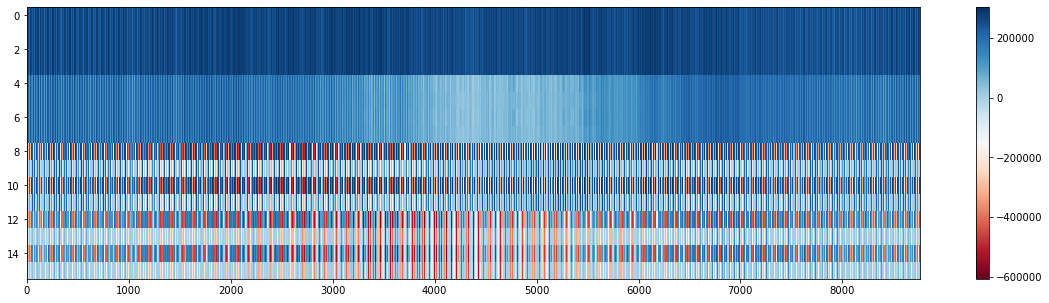

In [132]:
plt.figure(figsize = (20, 5))
plt.imshow(H_net_prime_, aspect = 'auto', interpolation = 'none', cmap = 'RdBu')
plt.colorbar()
plt.show()